In [1]:
import os 
import sys
import re 
import glob
import json



from pycocotools.coco import COCO
import pandas as pd 
import numpy as np 
import torch
import torchvision
import cv2 
import matplotlib.pyplot as plt 
from matplotlib import patches
from PIL import Image

 

current_dir = os.getcwd()

 
dataset_dir = os.path.join(current_dir, 'dataset')


sys.path.insert(0, dataset_dir)


In [ ]:


def plot_coco_bboxes(coco_json_path, image_dir):
    # Load COCO annotations
    coco = COCO(coco_json_path)

    # Get the first image
    img_ids = coco.getImgIds()
    first_img_id = img_ids[0]
    first_image_info = coco.loadImgs(first_img_id)[0]
    print(first_image_info)
    # Load the image
    image_path = f"{image_dir}/{first_image_info['file_name']}"
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get annotations for the first image
    ann_ids = coco.getAnnIds(imgIds=first_img_id)
    annotations = coco.loadAnns(ann_ids)

    # Draw bounding boxes
    for ann in annotations:
        if 'bbox' in ann:
            x, y, width, height = ann['bbox']
            # Convert to integer
            x, y, width, height = int(x), int(y), int(width), int(height)
            # Draw the rectangle
            cv2.rectangle(image_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)
            # Optionally, put the class ID on the image
            category_id = ann['category_id']
            category_name = coco.loadCats(category_id)[0]['name']
            label = f'{category_name}'
            cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title('Image with Bounding Boxes')
    plt.show()

# Example usage
coco_json_path = 'dataset\\CamVid\\train.json'  # Replace with your actual COCO JSON path
image_dir = 'dataset\\CamVid\\train'  # Replace with your actual image directory
plot_coco_bboxes(coco_json_path, image_dir)

### Brainwash Dataset 

In [3]:
def replace_multiple(text, replacements):
    # Create a regex pattern that matches any of the keys
    pattern = re.compile("|".join(re.escape(key) for key in replacements.keys()))
    
    # Function to return the replacement value
    return pattern.sub(lambda match: replacements[match.group(0)], text)


def turn_toInt(x):
    x = x.lstrip().rstrip()    
    x =int(float(x))
    return x


replacements = {
    '(' :"",
    ')' : "",
    ';': "",
}

In [4]:


file_paths = glob.glob(os.path.join(dataset_dir, 'brainwash', '*.idl'), recursive=True)







for file_path in file_paths:
    print(file_path)
    with open(file_path,'r') as file:
        content = file.readlines()

    coco_format = {
    "images": [],
    "annotations": [],
    "categories": [
        {
            "id": 1,
            "name": "person",  
            "supercategory": "none"
        }
    ]
}




    bb_per_line = []
    for i,line in enumerate(content):
        line_arr  = line.rstrip().split(':')
        if(len(line_arr)==2):
            img_name = line_arr[0]
            img_name = os.path.basename(line_arr[0])
            boxes =  replace_multiple(line_arr[1],replacements).split(',')
            
            boxes = np.asarray(list(map(turn_toInt,boxes)))
            boxes = boxes.reshape(-1, 4)
            boxes= list(boxes)
            bb_per_line.append(boxes)
            image_info = {
                "id": i + 1,  # Unique image ID
                "file_name": img_name,
                "width": 640,  # Set your image width
                "height": 480  # Set your image height
            }
            coco_format["images"].append(image_info)
            for bbox_id, bbox in enumerate(boxes, start=1):
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min
                coco_format["annotations"].append({
                    "id": i + 1,
                    "image_id": image_info["id"],
                    "category_id": 1,  # Corresponding category ID
                    "bbox": [int(x_min), int(y_min), int(width), int(height)],  # COCO format: [x, y, width, height]
                    "area": float(width * height),  # Area of the bounding box
                    "iscrowd": 0,  # 0 if not a crowd
                    "segmentation": []
                })
            
    file_name_with_extension = os.path.basename(file_path)
    output_file, _ = os.path.splitext(file_name_with_extension)
    output_path = os.path.join('dataset\\brainwash',f'{output_file}.json')
    with open(output_path, 'w') as json_file:
        
        json.dump(coco_format, json_file, indent=4)

        print(f"COCO format data has been saved to {output_path}.")
        
    

## CamVid

In [5]:
camvid_dataset_path = f'dataset\CamVid'
label_mask =[]
label_df = pd.read_csv("dataset\CamVid\class_dict.csv")

images_test = glob.glob(os.path.join(camvid_dataset_path,'test','*.png'),recursive=True)
images_train =glob.glob(os.path.join(camvid_dataset_path,'train','*.png'),recursive=True)
images_val = glob.glob(os.path.join(camvid_dataset_path,'val','*.png'),recursive=True)

labels_test =glob.glob(os.path.join(camvid_dataset_path,'test_labels','*.png'),recursive=True)
labels_train =glob.glob(os.path.join(camvid_dataset_path,'train_labels','*.png'),recursive=True)
labels_val = glob.glob(os.path.join(camvid_dataset_path,'val_labels','*.png'),recursive=True)



zipped_test = list(zip(images_test, labels_test))
zipped_train = list(zip(images_train, labels_train))
zipped_val = list(zip(images_val, labels_val))

datasets = [zipped_train,zipped_test,zipped_val]

class_colours  = {}
for index , row in label_df.iterrows():
    class_colours[row['name']] = (row['b'],row['g'],row['r']) #cv rads images as bgr


In [ ]:
coco_format = {
    "images": [],
    "annotations": [],
    "categories": []
}

# Define a list of categories
categories = {class_name: idx + 1 for idx, class_name in enumerate(class_colours.keys())}

# Populate categories
for class_name, class_id in categories.items():
    coco_format["categories"].append({
        "id": class_id,
        "name": class_name,
        "supercategory": "none"  # You can define supercategories if needed
    })

# Initialize counters
image_id = 0
annotation_id = 0

dataset_names = ['train','test','val']
# Dictionary to store contours
contours_dict = {}
for j,dataset  in enumerate(datasets):
    for image_path, label_path in dataset:
        
        label_image = cv2.imread(label_path)
        image = cv2.imread(image_path)
        label_image_gray = cv2.cvtColor(label_image, cv2.COLOR_BGR2GRAY)
        
        
        
        # Add image metadata
        height, width, _ = image.shape
        coco_format["images"].append({
            "id": image_id,
            "file_name": os.path.basename(image_path),  # Get the filename
            "height": height,
            "width": width
        })

        # Step 1: Iterate through each class color
        for class_name, color in class_colours.items():
            # Create a binary mask for the current class using RGB encoding
            mask = cv2.inRange(label_image, color, color)

            # Step 2: Find contours in the binary mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Store the contours in the dictionary
            contours_dict[class_name] = contours

            # Step 3: Draw bounding boxes for each contour
            for contour in contours:
                # Get the bounding box for the contour
                x, y, w, h = cv2.boundingRect(contour)

                # Create an annotation
                coco_format["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": categories[class_name],
                    "bbox": [x, y, w, h],  # [x, y, width, height]
                    "area": w * h,  # Area of the bounding box
                    "iscrowd": 0,  # Set to 1 if the object is a crowd
                    "segmentation": [],  # You can add segmentation data if available
                    "keypoints": [],  # You can add keypoints if available
                })
                annotation_id += 1

        image_id += 1

    
    
    output_path = os.path.join('dataset\\CamVid',f'{dataset_names[j]}.json')
    with open(output_path, 'w') as json_file:
        
        json.dump(coco_format, json_file, indent=4)

        print(f"COCO format data has been saved to {output_path}.")
    

## Crowd UIT

In [7]:
label_paths = glob.glob(os.path.join(dataset_dir, 'brainwash', '*.idl'), recursive=True)
images_paths   = glob.glob(os.path.join(dataset_dir, 'brainwash', '*.idl'), recursive=True)

### HT21

In [ ]:
label_paths_test = glob.glob(os.path.join(dataset_dir, 'HT21', 'test', '**', 'det', '*.txt'), recursive=True)
images_paths_test = glob.glob(os.path.join(dataset_dir, 'HT21', 'test', '**', 'img1', '*.jpg'), recursive=True)

# For train set
label_paths_train = glob.glob(os.path.join(dataset_dir, 'HT21', 'train', '**', 'gt', '*.txt'), recursive=True)
images_paths_train = glob.glob(os.path.join(dataset_dir, 'HT21', 'train', '**', 'img1', '*.jpg'), recursive=True)

# Print the paths for verification (optional)
print("Test Label Paths:", label_paths_test)
print("Test Image Paths:", images_paths_test)
print("Train Label Paths:", label_paths_train)
print("Train Image Paths:", images_paths_train)





subfolder_images = {}

# Iterate through the image paths
for image_path in images_paths_train:
    # Get the subfolder name (the part of the path after 'train/')
    subfolder = os.path.dirname(image_path).split(os.sep)[-2]  # Get the immediate subfolder after 'train'
    
    # Add the image path to the corresponding subfolder list
    if subfolder not in subfolder_images:
        subfolder_images[subfolder] = []
    subfolder_images[subfolder].append(image_path)

# Convert the dictionary values to a list of lists
list_of_lists = list(subfolder_images.values())

In [ ]:




column_names = ['frame', 'object_id', 'x1', 'y1', 'width', 'height', 'confidence', 'class_id', 'visibility']


# Assuming list_of_lists and label_paths_train are defined
for image_paths_HT, label_HT in zip(list_of_lists, label_paths_train):
    coco_format = {
    "images": [],
    "annotations": [],
    "categories": []
    }

# Define the single category
    category_id = 1
    category_name = "person"

# Add the category to the COCO format
    coco_format["categories"].append({
    "id": category_id,
    "name": category_name
    })

    

    # Load the CSV file with the specified column names
    df = pd.read_csv(label_HT, names=column_names)
    df.drop(['object_id', 'confidence', 'class_id', 'visibility'], axis=1, inplace=True)
    df['frame'] = df['frame'] - 1  # Adjust frame numbers if needed

    for i in range(len(image_paths_HT)):
        # Load the image using OpenCV
        img_path = image_paths_HT[i]
        img = cv2.imread(img_path)

        # Get image dimensions
        height, width, _ = img.shape

        # Add image information to COCO format
        coco_format["images"].append({
            "id": i,
            "file_name": os.path.basename(img_path),
            "width": width,
            "height": height
        })

        # Get the bounding boxes for the current frame
        current_frame = df[df['frame'] == i]

        # Draw each bounding box on the image and add annotations to COCO format
        for _, row in current_frame.iterrows():
            # Draw a rectangle (x1, y1) is the top-left corner, and (x1 + width, y1 + height) is the bottom-right corner
            cv2.rectangle(img, (int(row['x1']), int(row['y1'])), 
                          (int(row['x1'] + row['width']), int(row['y1'] + row['height'])), 
                          (0, 255, 0), 2)  # Green color with thickness 2

            # Add annotation information to COCO format
            coco_format["annotations"].append({
                "id": len(coco_format["annotations"]) + 1,
                "image_id": i,
                "category_id": category_id,  # Category ID for "person"
                "bbox": [row['x1'], row['y1'], row['width'], row['height']],
                "area": row['width'] * row['height'],
                "iscrowd": 0
            })

        # Convert the image from BGR to RGB
        # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # # Display the image with bounding boxes using Matplotlib
        # plt.imshow(img_rgb)
        # plt.title(f'Frame: {i}')
        # plt.axis('off')  # Hide axes
        # plt.show()  # Display the image

        # Wait for a key press to move to the next image
        #input("Press Enter to continue...")  # Pause until the user presses Enter

# Save the COCO format data to a JSON file
    output_name= 'annotation.json'
    output_full_path = os.path.join(*label_HT.split(os.sep)[6:-2])
    
    with open(os.path.join(output_full_path,output_name), 'w') as json_file:
        json.dump(coco_format, json_file, indent=4)

        print(f"COCO format annotations saved to '{output_full_path}'.")

## Dense Tracking dataset
useless its dots agai

In [10]:
mat_file_path ='dataset\Dense_Tracking_Dataset\GroundTruth\GT03.mat'


In [ ]:
import numpy as np
import scipy.io

# Load the .mat file (older format)
  # Replace with your .mat file path
mat_data = scipy.io.loadmat(mat_file_path)

# Display the keys in the loaded data
print("Keys in the .mat file:", mat_data.keys())

# Access a specific variable
variable_name = 'GT'  # Replace with the actual variable name
data = mat_data[variable_name]['y']

# Print the data
print("Data for variable '{}':".format(variable_name), data)

### eople camera walking

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
{'id': 0, 'file_name': 'frame_000000.PNG', 'width': 1280, 'height': 720}


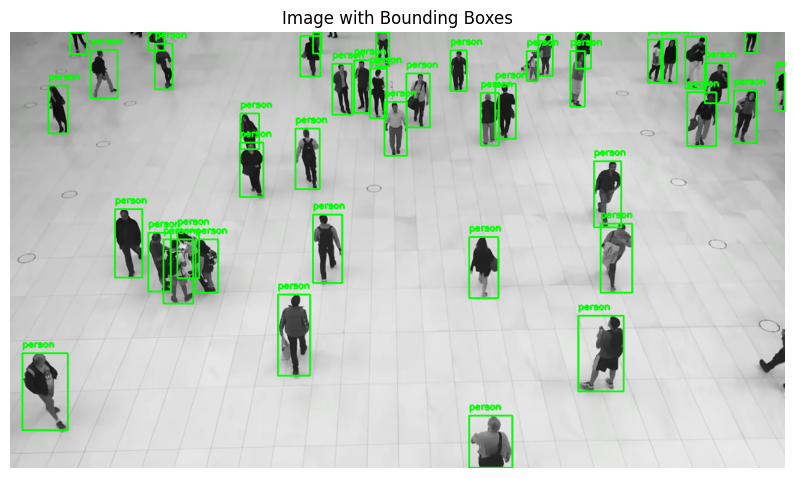

In [36]:
import lxml.etree as ET
import os
import glob
import json
import cv2  # Import OpenCV

# Parse the XML file
tree = ET.parse("dataset/people_camer_walking/annotations.xml")
root = tree.getroot()

# Dictionary to store bounding boxes for each track ID
track_dict = {}

# Iterate through the <track> elements and extract <box> elements
for track in root.findall('.//track'):
    track_id = track.get('id')
    if track_id not in track_dict:
        track_dict[track_id] = []

    for box in track.findall('.//box'):
        frame = int(box.get('frame'))  # Convert frame to int
        xtl = float(box.get('xtl'))
        ytl = float(box.get('ytl'))
        xbr = float(box.get('xbr'))
        ybr = float(box.get('ybr'))
        
        # Calculate width and height
        width = xbr - xtl
        height = ybr - ytl
        
        # Ensure width and height are positive
        if width < 0 or height < 0:
            print(f"Warning: Negative width or height for track ID {track_id} at frame {frame}.")
            continue
        
        # Store bounding box coordinates
        track_dict[track_id].append({
            "frame": frame,
            "bbox": [xtl, ytl, width, height]  # Store as [x, y, width, height]
        })

# Function to load filenames from the images folder using glob
def load_filenames(folder_path):
    return glob.glob(os.path.join(folder_path, "*.PNG"))  # Adjust the extension as needed

# Load filenames
image_folder = "dataset/people_camer_walking/images"
image_paths = load_filenames(image_folder)

# Create COCO format data
coco_data = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "person"}]  # Assuming class ID 0 is for 'person'
}

# Populate images and annotations
for index, image_path in enumerate(image_paths):
    image_id = index
    
    # Use OpenCV to get the image dimensions
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}. Skipping.")
        continue
    
    image_height, image_width = image.shape[:2]  # Get height and width from OpenCV

    coco_data["images"].append({
        "id": image_id,
        "file_name": os.path.basename(image_path),
        "width": image_width,
        "height": image_height
    })

    # Add annotations for each track
    for track_id, boxes in track_dict.items():
        for box in boxes:
            if box["frame"] == index:  # Match frame number with image index
                coco_data["annotations"].append({
                    "id": len(coco_data["annotations"]) + 1,
                    "image_id": image_id,
                    "category_id": 0,  # Assuming class ID 0 is for 'person'
                    "bbox": [
                        box["bbox"][0],  # x (top-left corner)
                        box["bbox"][1],  # y (top-left corner)
                        box["bbox"][2],  # width
                        box["bbox"][3]   # height
                    ],
                    "area": box["bbox"][2] * box["bbox"][3],  # width * height
                    "iscrowd": 0,
                    "segmentation": []  # Add segmentation if available
                })

# Save COCO data to JSON file
with open("dataset/people_camer_walking/annotations.json", "w") as json_file:
    json.dump(coco_data, json_file, indent=4)



# Function to plot COCO bounding boxes (assuming you have this function defined)
plot_coco_bboxes("dataset/people_camer_walking/annotations.json",image_folder)
